###DEEP LEARNING
###HW4.1

https://github.com/bentrevett/pytorch-seq2seq.git

In [ ]:
!pip install shap

In [2]:
import re
import shap
import time
import math
import torch
import random
import torchtext
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchtext.data import get_tokenizer
from sklearn.model_selection import train_test_split
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
random.seed(21)
np.random.seed(21)
torch.manual_seed(21)
torch.cuda.manual_seed(21)
torch.backends.cudnn.deterministic = True

In [4]:
with open('/content/ferdousi.txt') as f: poems = [line.strip() for line in f.readlines()]
poems = poems[2:]

In [5]:
first_part = []
second_part = []
for i in range(len(poems)):
  if i % 2 == 0:
    first_part.append(poems[i])
  else:
    second_part.append(poems[i])
first_part, second_part = first_part[0:49608], second_part[0:49608]

In [6]:
first_part =enumerate(first_part)
second_part =enumerate(second_part)

In [7]:
tokenizer = get_tokenizer("basic_english")
def build_vocab(datasets):
    for dataset in datasets:
        for _, text in dataset:
            yield tokenizer(text)

In [8]:
token_generator = build_vocab([first_part, second_part])
vocab = build_vocab_from_iterator(token_generator,
                                  min_freq=1,
                                  specials=['<unk>', '<start>', '<end>'])
vocab.set_default_index(vocab["<unk>"])

In [9]:
tokens = tokenizer("پارسیان و من")
indexes = vocab(tokens)

tokens, indexes

(['پارسیان', 'و', 'من'], [0, 3, 23])

In [10]:
tokens = tokenizer("<eos>")
indexes = vocab(tokens)

print(tokens, indexes)
print(vocab["<sos>"])
print(vocab.get_itos()[18010])
print(vocab.get_itos()[3])

['<eos>'] [0]
0
ییک
و


In [11]:
first_part = []
second_part = []
for i in range(len(poems)):
  if i % 2 == 0:
    first_part.append(poems[i])
  else:
    second_part.append(poems[i])
first_part, second_part = first_part[0:49608], second_part[0:49608]

In [12]:
X_TV, X_test, y_TV, y_test = train_test_split(first_part, second_part, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_TV, y_TV, test_size=0.25, random_state=42)

In [13]:
train_data, test_data, val_data = [], [], []
for i in range(len(X_train)):
  train_data.append([X_train[i], y_train[i]])
for i in range(len(X_test)):
  test_data.append([X_test[i], y_test[i]])
for i in range(len(X_val)):
  val_data.append([X_val[i], y_val[i]])

In [14]:
print("train length", len(train_data),"\ntest length", len(test_data), "\nval length", len(val_data))

train length 29764 
test length 9922 
val length 9922


In [15]:
def vb(b):
    IP, OP = list(zip(*b))
    IP = [vocab(tokenizer(S)) for S in IP]
    IP = [S+([0]* (9-len(S))) if len(S)<9 else S[:9] for S in IP]
    OP = [vocab(tokenizer(sample)) for sample in OP]
    OP = [S+([0]* (9-len(S))) if len(S)<9 else S[:9] for S in OP]
    IPP,OPP = [], []
    for i in IP:
      ii = list(i)
      ii.insert(0,1)
      ii.append(2)
      IPP.append(ii)
    for j in OP:
      jj = list(j)
      jj.insert(0,1)
      jj.append(2)
      OPP.append(jj)
    return torch.tensor(IPP, dtype=torch.int32).transpose(0, 1).to(device),torch.tensor(OPP, dtype=torch.int32).transpose(0, 1).to(device)

In [16]:
train_data, test_data, val_data = to_map_style_dataset(train_data), to_map_style_dataset(test_data), to_map_style_dataset(val_data)
train_loader = DataLoader(train_data, batch_size=1024, collate_fn=vb)
test_loader  = DataLoader(test_data, batch_size=1024, collate_fn=vb)
val_loader  = DataLoader(val_data, batch_size=1024, collate_fn=vb)

In [17]:
first_batch = next(iter(train_loader))

In [18]:
first_batch[1].shape

torch.Size([11, 1024])

In [19]:
for X, Y in train_loader:
    print(X.shape, Y.shape)
    break

torch.Size([11, 1024]) torch.Size([11, 1024])


In [20]:
first_batch[0][:,0].shape

torch.Size([11])

##A

In [21]:
class encoder(nn.Module):

    def __init__(self, id, ed, hd, nl, dropout):

        super().__init__()
        self.hd = hd
        self.nl = nl
        self.dropout = nn.Dropout(dropout)
        self.Embddng = nn.Embedding(id, ed)
        self.RNN = nn.LSTM(ed, hd, nl, dropout = dropout)
        
    def forward(self, source):
        
        #source = [source len, batch size]
        embedded = self.dropout(self.Embddng(source))
        #embedded = [source len, batch size, emb dim]
        outputs, (hidden, cell) = self.RNN(embedded)
        #outputs = [source len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        #outputs are always from the top hidden layer
        return hidden, cell

In [22]:
class decoder(nn.Module):
    def __init__(self, od, ed, hd, nl, dropout):

        super().__init__()
        self.od = od
        self.hd = hd
        self.nl = nl
        self.Embddng = nn.Embedding(od, ed)
        self.fc = nn.Linear(hd, od)
        self.dropout = nn.Dropout(dropout)
        self.probs = nn.Softmax(dim=1)
        self.RNN = nn.LSTM(ed, hd, nl, dropout = dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.Embddng(input))
        
        #embedded = [1, batch size, emb dim]
                
        output, (hidden, cell) = self.RNN(embedded, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return self.probs(prediction), hidden, cell

In [23]:
class MODEL(nn.Module):
    def __init__(self, encdr, dcdr, dvce):
        super().__init__()
        
        self.encdr = encdr
        self.dcdr = dcdr
        self.device = dvce
        
        assert encdr.hd == dcdr.hd, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encdr.nl == dcdr.nl, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, sorce, target, ratio = 0.5):

        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = target.shape[1]
        trg_len = target.shape[0]
        vocab_size = self.dcdr.od
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encdr(sorce)
        
        #first input to the decoder is the <sos> tokens
        input = target[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.dcdr(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            tforce = random.random() < ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = target[t] if tforce else top1
        
        return outputs

In [24]:
model = MODEL(encoder(len(vocab), 256, 512, 2, 0.5), decoder(len(vocab), 256, 512, 2, 0.5), device).to(device)

In [25]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

MODEL(
  (encdr): encoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (Embddng): Embedding(18011, 256)
    (RNN): LSTM(256, 512, num_layers=2, dropout=0.5)
  )
  (dcdr): decoder(
    (Embddng): Embedding(18011, 256)
    (fc): Linear(in_features=512, out_features=18011, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (probs): Softmax(dim=1)
    (RNN): LSTM(256, 512, num_layers=2, dropout=0.5)
  )
)

In [26]:
optimizer = optim.Adam(model.parameters())

In [27]:
LOSS = nn.CrossEntropyLoss(ignore_index = vocab.get_stoi()["<unk>"]).to(device)

In [28]:
len(first_batch[1])

11

In [29]:
def evaluate(model, val_loader, LOSS):
    
    model.eval()
    
    epoch_loss = 0
    correct = 0
    with torch.no_grad():
    
        for i, batch in enumerate(val_loader):

            src, trg = batch

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:,].reshape(output.shape[0])
            trg = trg.type(torch.LongTensor).to(device)
            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]
            loss = LOSS(output, trg)
            correct += (output.argmax(1) == trg).type(torch.float).sum().item()
            epoch_loss += loss.item()
    correct /= trg.shape[0]
    return correct , epoch_loss / len(val_loader)

In [30]:
def train(model, train_loader, optimizer, LOSS, clip):
    
    model.train()
    
    epoch_loss = 0
    correct = 0
    for i, batch in enumerate(train_loader):

        src, trg = batch
        optimizer.zero_grad()
        output = model(src, trg)

        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        # print("out", output.shape)
        # print("argmax", output.argmax(2).shape)
        output = output[1:,].view(-1, output_dim)
        trg = trg[1:,].reshape(output.shape[0])

        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        # print("out", trg.shape)
        trg = trg.type(torch.LongTensor).to(device)
        loss = LOSS(output, trg)
        correct += (output.argmax(1) == trg).type(torch.float).sum().item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
    correct /= trg.shape[0]
    return correct, epoch_loss / len(train_loader)

In [31]:
best_v_loss = float(100000)
train_history = []
val_history = []
for epoch in range(4):
    t_acc, t_loss = train(model, train_loader, optimizer, LOSS, 1)
    v_acc, v_loss = evaluate(model, val_loader, LOSS)
    train_history += [t_loss]
    val_history += [v_loss]
    if v_loss < best_v_loss:
        best_v_loss = v_loss
        torch.save(model.state_dict(), 'lstmmodel.pt')
    print(f'train loss: {t_loss:.3f}\ntrain acc: {t_acc:.3f}')
    print(f'validation loss: {v_loss:.3f}\nvalidation accuracy: {v_acc:.3f}')
    print("===========================\n==============================")

train loss: 9.692
train acc: 41.763
validation loss: 9.624
validation accuracy: 1.664
train loss: 9.598
train acc: 59.497
validation loss: 9.593
validation accuracy: 1.951
train loss: 9.593
train acc: 60.765
validation loss: 9.593
validation accuracy: 1.951
train loss: 9.593
train acc: 60.765
validation loss: 9.593
validation accuracy: 1.951


[]

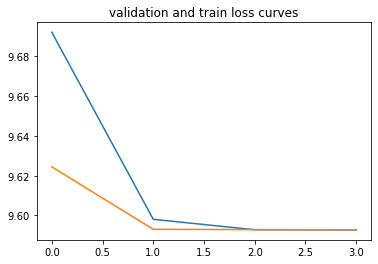

In [32]:
e = range(4)
plt.plot(e, train_history)
plt.plot(e, val_history)
plt.title("validation and train loss curves")
plt.plot()

##B

In [33]:
class encdr(nn.Module):

    def __init__(self, id, ed, hd, nl, dropout):

        super().__init__()
        self.hd = hd
        # self.n_layers = n_layers
        self.embedding = nn.Embedding(id, ed)
        self.gru = nn.GRU(ed, hd)
        self.dropout = nn.Dropout(dropout)
    def forward(self, suorce):
        
        #suorce = [suorce len, batch size]
        embedded = self.dropout(self.embedding(suorce))
        #embedded = [suorce len, batch size, emb dim]
        outputs, hidden = self.gru(embedded)
        #outputs = [suorce len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        #outputs are always from the top hidden layer
        return hidden

In [34]:
class dcdr(nn.Module):
    def __init__(self, od, ed, hd, nl, dropout):

        super().__init__()
        self.od = od
        self.hd = hd
        # self.n_layers = n_layers
        self.Embddng = nn.Embedding(od, ed)
        self.gru = nn.GRU(ed + hd, hd)
        self.fc = nn.Linear(ed + hd * 2, od)
        self.dropout = nn.Dropout(dropout)
        self.probs = nn.Softmax(dim=1)
        
    def forward(self, input, hidden, z):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.Embddng(input))
        
        #embedded = [1, batch size, emb dim]
        ec = torch.cat((embedded, z), dim = 2)
        output, hidden = self.gru(ec, hidden)
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        output = torch.cat((embedded.squeeze(0), hidden.squeeze(0), z.squeeze(0)), dim = 1)
        prediction = self.fc(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden

In [40]:
class MODEL(nn.Module):
    def __init__(self, encdr, dcdr, dvce):
        super().__init__()
        self.encdr = encdr
        self.dcdr = dcdr
        self.device = dvce
    def forward(self, sorce, trget, ratio = 0.5):

        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher forcing ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trget.shape[1]
        vocab_size = self.dcdr.od
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trget.shape[0], batch_size, vocab_size).to(self.device)
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        Z = self.encdr(sorce)
        hidden = Z
        #first input to the decoder is the <start> tokens
        input = trget[0,:]
        
        for t in range(1, trget.shape[0]):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden=self.dcdr(input, hidden, Z)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trget[t] if teacher_force else top1
        
        return outputs

In [41]:
model = MODEL(encdr(len(vocab), 256, 512, 2, 0.5),
              dcdr(len(vocab), 256, 512, 2, 0.5),
              device).to(device)

In [42]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = vocab.get_stoi()["<unk>"]).to(device)

In [43]:
best_v_loss = float(100000)
train_history = []
val_history = []
for epoch in range(4):
    t_acc, t_loss = train(model, train_loader, optimizer, criterion, 1)
    v_acc, v_loss = evaluate(model, val_loader, criterion)
    train_history += [t_loss]
    val_history += [v_loss]
    if v_loss < best_v_loss:
        best_v_loss = v_loss
        torch.save(model.state_dict(), 'lstmmodel.pt')
    print(f'train loss: {t_loss:.3f}\ntrain acc: {t_acc:.3f}')
    print(f'validation loss: {v_loss:.3f}\nvalidation accuracy: {v_acc:.3f}')
    print("===========================\n==============================")

train loss: 6.483
train acc: 51.351
validation loss: 5.960
validation accuracy: 1.879
train loss: 5.707
train acc: 60.882
validation loss: 5.813
validation accuracy: 1.932
train loss: 5.469
train acc: 63.440
validation loss: 5.681
validation accuracy: 1.998
train loss: 5.159
train acc: 67.750
validation loss: 5.569
validation accuracy: 2.089


همانطور که از دوبخش الف و ب مشاهده شد استفاده از جی.آر.یو و یک تکنیک دیگر منجر به کاهش لاس و افرایش دقت شد